## Preprocessing

In this first phase we are focusing on getting only the High Resolutions images for the patients that respect the neccessary quality.

In [1]:
import os
import nibabel as nib
import numpy as np
import glob
import json
import pandas as pd
from collections import defaultdict
import shutil

Getting only high resolution MRI by checking:
- SliceThickness
- ImageOrientationPatientDICOM

In [15]:
def get_sagittal_slices(input_dir, output_dir):
    json_files = glob.glob(f'{input_dir}/**/*.json', recursive=True)

    des = output_dir
    os.makedirs(des, exist_ok=True)
    
    for json_file in json_files:
        try:
            with open(json_file) as f:
                data = json.load(f)

            if 'SliceThickness' in data and data['SliceThickness'] <= 1.5:
                if 'ImageOrientationPatientDICOM' in data and data['ImageOrientationPatientDICOM'][1] > 0.9 and abs(data['ImageOrientationPatientDICOM'][5]) > 0.9:
                    
                    nii_file = json_file.replace('.json', '.nii.gz')
                    
                    os.system(f"cp '{json_file}' {des}")
                    os.system(f"cp '{nii_file}' {des}")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in {json_file}: {e}")
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

In [16]:
input_dir = '/scratch/Costanza/ADNI_DDPM_NIfTI'
output_dir = '/scratch/Costanza/ADNI_DDPM_Sagittal'
get_sagittal_slices(input_dir, output_dir)

Extration of the patient ID

In [2]:
def extract_patient_id(filename):
    base_name = os.path.basename(filename)
    patient_id = base_name.split('_')[2]
    return patient_id

Number of patients in the ADNI_DDPM_Sagittal Dataset

In [3]:
def find_all_patients(input_dir):
    json_files = glob.glob(f'{input_dir}/**/*.json', recursive=True)
    all_patients = set()
    
    for json_file in json_files:
        try:
            patient_id = extract_patient_id(json_file)
            all_patients.add(patient_id)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_patients

input_dir = '/scratch/Costanza/ADNI_DDPM_Sagittal'
all_patients = find_all_patients(input_dir)
print(f'The total number of the patents in this dataset directory {input_dir} is {len(all_patients)}')

The total number of the patents in this dataset directory /scratch/Costanza/ADNI_DDPM_Sagittal is 99


Check SeriesDescription in ADNI_DDPM_Sagittal to verify which patients have both MagneticFieldStrength

In [132]:
def find_patients_with_both_FS_for_SD(input_dir, output_csv):
    json_files = glob.glob(f'{input_dir}/**/*.json', recursive=True)
    
    patient_scans = defaultdict(lambda: defaultdict(list))
    
    for json_file in json_files:
        try:
            with open(json_file) as f:
                data = json.load(f)

            if 'MagneticFieldStrength' in data and 'SeriesDescription' in data:
                patient_id = extract_patient_id(json_file)
                field_strength = data['MagneticFieldStrength']
                series_description = data['SeriesDescription']
                patient_scans[patient_id][field_strength].append(series_description)

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in {json_file}: {e}")
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    patients_with_both = {
        patient: field_strengths 
        for patient, field_strengths in patient_scans.items() 
        if 1.5 in field_strengths and 3.0 in field_strengths
    }
    
    rows = []
    for patient, field_strengths in patients_with_both.items():
        series_descriptions_1_5 = set(field_strengths[1.5])
        series_descriptions_3_0 = set(field_strengths[3.0])
        common_series_descriptions = series_descriptions_1_5.intersection(series_descriptions_3_0)
        
        for series_description in common_series_descriptions:
            rows.append((patient, 1.5, series_description))
            rows.append((patient, 3.0, series_description))
    
    df = pd.DataFrame(rows, columns=['PatientID', 'MagneticFieldStrength', 'SeriesDescription'])
    df['PatientID'] = df['PatientID'].apply(lambda x: x.zfill(4))
    df.to_csv(output_csv, index=False)
    num_patients = df['PatientID'].nunique()

    return num_patients

input_dir = '/scratch/Costanza/ADNI_DDPM_Sagittal'
output_csv = '/scratch/Costanza/Check/MFS&SD_sagittal_check.csv'
num_patients = find_patients_with_both_FS_for_SD(input_dir, output_csv)
print(f"Number of unique patients with both 1.5T and 3T scans with common series descriptions: {num_patients}")

Number of unique patients with both 1.5T and 3T scans with common series descriptions: 44


Table of SeriesDescriptions available for patient that have both 1.5T and 3T MagneticFieldStrength 

In [133]:
file_path = '/scratch/Costanza/Check/MFS&SD_sagittal_check.csv'
df = pd.read_csv(file_path)

filtered_df = df.groupby(['PatientID', 'SeriesDescription'])['MagneticFieldStrength'].apply(lambda x: set(x) == {1.5, 3.0}).reset_index()

filtered_df = filtered_df[filtered_df['MagneticFieldStrength']]

count_series_description = filtered_df['SeriesDescription'].value_counts().reset_index()
count_series_description.columns = ['SeriesDescription', 'PatientCount']

total_patient = count_series_description['PatientCount'].sum()

count_series_description


SeriesDescription  PatientCount
0            MPRAGE            33
1     MPRAGE Repeat            13
2    MP-RAGE REPEAT            11
3           MP-RAGE            10
4     MPRAGE REPEAT             1

The total of the column Patient Count is 68, but I only 44 unique patients in the CSV file, it indicates that some patients have multiple series descriptions associated with them.

Function that clean the dataset and get just the patients that we need. From 99 we found just 44 patients with the characteristics that we want.

In [5]:
def get_patients(input_dir, output_dir):
    json_files = glob.glob(f'{input_dir}/**/*.json', recursive=True)
    
    patient_scans = defaultdict(lambda: defaultdict(list))
    
    for json_file in json_files:
        try:
            with open(json_file) as f:
                data = json.load(f)

            if 'MagneticFieldStrength' in data and 'SeriesDescription' in data:
                patient_id = extract_patient_id(json_file)
                field_strength = data['MagneticFieldStrength']
                series_description = data['SeriesDescription']
                patient_scans[patient_id][field_strength].append((series_description, json_file))

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in {json_file}: {e}")
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    patients_with_both = {
        patient: field_strengths 
        for patient, field_strengths in patient_scans.items() 
        if 1.5 in field_strengths and 3.0 in field_strengths
    }

    filtered_patients = {}
    for patient, field_strengths in patients_with_both.items():
        series_descriptions_1_5 = set(desc for desc, _ in field_strengths[1.5])
        series_descriptions_3_0 = set(desc for desc, _ in field_strengths[3.0])
        common_series_descriptions = series_descriptions_1_5.intersection(series_descriptions_3_0)
        
        if common_series_descriptions:
            filtered_patients[patient] = field_strengths
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for patient, field_strengths in filtered_patients.items():
        series_descriptions_1_5 = {desc: file for desc, file in field_strengths[1.5]}
        series_descriptions_3_0 = {desc: file for desc, file in field_strengths[3.0]}
        common_series_descriptions = set(series_descriptions_1_5.keys()).intersection(series_descriptions_3_0.keys())
        
        for series_description in common_series_descriptions:
            json_file_1_5 = series_descriptions_1_5[series_description]
            json_file_3_0 = series_descriptions_3_0[series_description]
            
            image_file_1_5 = json_file_1_5.replace('.json', '.nii.gz') 
            image_file_3_0 = json_file_3_0.replace('.json', '.nii.gz')
            
            patient_output_dir = os.path.join(output_dir, patient)
            if not os.path.exists(patient_output_dir):
                os.makedirs(patient_output_dir)
            
            json_file_1_5_new = os.path.join(patient_output_dir, f'{os.path.basename(json_file_1_5).replace(".json", "")}_1.5T.json')
            image_file_1_5_new = os.path.join(patient_output_dir, f'{os.path.basename(image_file_1_5).replace(".nii.gz", "")}_1.5T.nii.gz')
            json_file_3_0_new = os.path.join(patient_output_dir, f'{os.path.basename(json_file_3_0).replace(".json", "")}_3.0T.json')
            image_file_3_0_new = os.path.join(patient_output_dir, f'{os.path.basename(image_file_3_0).replace(".nii.gz", "")}_3.0T.nii.gz')
            
            shutil.copy(json_file_1_5, json_file_1_5_new)
            shutil.copy(image_file_1_5, image_file_1_5_new)
            shutil.copy(json_file_3_0, json_file_3_0_new)
            shutil.copy(image_file_3_0, image_file_3_0_new)
    
    num_patients = len(filtered_patients)
    return num_patients

input_dir = '/scratch/Costanza/ADNI_DDPM_Sagittal'
output_dir = '/scratch/Costanza/ADNI_DDPM_S_Clean'
num_patients = get_patients(input_dir, output_dir)
print(f"Number of unique patients with both 1.5T and 3T scans with common series descriptions: {num_patients}")

Number of unique patients with both 1.5T and 3T scans with common series descriptions: 44


In [13]:
def check_patient_folder(patient_folder):
    nii_files = glob.glob(os.path.join(patient_folder, '*.nii.gz'))

    image_3T_files = []
    image_1_5T_files = []

    for nii_file in nii_files:
        if '3.0T' in nii_file:
            image_3T_files.append(nii_file)
        elif '1.5T' in nii_file:
            image_1_5T_files.append(nii_file)

    num_pairs = min(len(image_3T_files), len(image_1_5T_files))

    if not image_3T_files:
        print(f"No 3.0T images found in {patient_folder}")
    if not image_1_5T_files:
        print(f"No 1.5T images found in {patient_folder}")

    return num_pairs, image_1_5T_files, image_3T_files

def check_all_patient_folders(input_dir):
    patient_folders = [f.path for f in os.scandir(input_dir) if f.is_dir()]
    complete_pairs_count = 0
    multiple_pairs_count = 0
    for patient_folder in patient_folders:
        num_pairs, _, _ = check_patient_folder(patient_folder)
        if num_pairs > 0:
            complete_pairs_count += 1
            if num_pairs > 1:
                multiple_pairs_count += 1
                print(f"Patient {os.path.basename(patient_folder)} has {num_pairs} pairs")
        else:
            print(f"Incomplete pairs in {patient_folder}")

    print(f"Total patients with complete pairs: {complete_pairs_count}")
    print(f"Total patients with multiple pairs: {multiple_pairs_count}")
    print(f"Total patients checked: {len(patient_folders)}")
    
input_dir = '/scratch/Costanza/ADNI_DDPM_S_Clean'
check_all_patient_folders(input_dir)


Patient 1169 has 2 pairs
Patient 1276 has 2 pairs
Patient 1241 has 2 pairs
Patient 0622 has 2 pairs
Patient 0058 has 2 pairs
Patient 0602 has 2 pairs
Patient 1251 has 2 pairs
Patient 1267 has 2 pairs
Patient 1206 has 2 pairs
Patient 0031 has 2 pairs
Patient 1288 has 2 pairs
Patient 0926 has 2 pairs
Patient 1190 has 2 pairs
Patient 1256 has 2 pairs
Patient 0605 has 2 pairs
Patient 0677 has 2 pairs
Patient 0061 has 2 pairs
Patient 0260 has 2 pairs
Patient 0479 has 2 pairs
Patient 0963 has 2 pairs
Patient 1035 has 2 pairs
Patient 1123 has 2 pairs
Patient 0553 has 2 pairs
Patient 1250 has 2 pairs
Total patients with complete pairs: 44
Total patients with multiple pairs: 24
Total patients checked: 44


As last step we are going to clean the dataset from unnecessary pairs of 1.5T and 3.0, remaning just with one couple of pair for patient.

In [11]:
def create_single_pairs_folder(input_dir, output_dir):
    patient_folders = [f.path for f in os.scandir(input_dir) if f.is_dir()]
    
    for patient_folder in patient_folders:
        num_pairs, image_1_5T_files, image_3T_files = check_patient_folder(patient_folder)

        if num_pairs > 0:
            # Only keep the first pair
            selected_1_5T_file = image_1_5T_files[0]
            selected_3T_file = image_3T_files[0]

            patient_id = os.path.basename(patient_folder)
            patient_output_dir = os.path.join(output_dir, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)

            shutil.copy(selected_1_5T_file, os.path.join(patient_output_dir, os.path.basename(selected_1_5T_file)))
            shutil.copy(selected_3T_file, os.path.join(patient_output_dir, os.path.basename(selected_3T_file)))

            json_1_5T_file = selected_1_5T_file.replace('.nii.gz', '.json')
            json_3T_file = selected_3T_file.replace('.nii.gz', '.json')

            if os.path.exists(json_1_5T_file):
                shutil.copy(json_1_5T_file, os.path.join(patient_output_dir, os.path.basename(json_1_5T_file)))
            if os.path.exists(json_3T_file):
                shutil.copy(json_3T_file, os.path.join(patient_output_dir, os.path.basename(json_3T_file)))

input_dir = '/scratch/Costanza/ADNI_DDPM_S_Clean'
output_dir = '/scratch/Costanza/ADNI_DDPM_S_Single_Pairs'
create_single_pairs_folder(input_dir, output_dir)


### After Registration and Convertion to PNG

In [2]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [3]:
dataset_dir = "/scratch/Costanza/ADNI_DDPM_S_R_PNG"

data_dicts = []

slice_pattern = re.compile(r'_slice_(\d+)\.png')

for patient_id in sorted(os.listdir(dataset_dir)):
    patient_dir = os.path.join(dataset_dir, patient_id)
    if os.path.isdir(patient_dir):
        slice_dict = {}
        
        for file_name in sorted(os.listdir(patient_dir)):
            match = slice_pattern.search(file_name)
            if match:
                slice_number = match.group(1)
                file_path = os.path.join(patient_dir, file_name)
                if '1.5T' in file_name:
                    if slice_number not in slice_dict:
                        slice_dict[slice_number] = {}
                    slice_dict[slice_number]['concat'] = file_path
                elif '3.0T' in file_name:
                    if slice_number not in slice_dict:
                        slice_dict[slice_number] = {}
                    slice_dict[slice_number]['img'] = file_path
        
        for slice_number, paths in slice_dict.items():
            if 'img' in paths and 'concat' in paths:
                data_dicts.append({
                    'img': paths['img'],
                    'concat': paths['concat'],
                    'cls': 0  
                })

In [4]:
def visualize_slices(patient_id):
    patient_dir = os.path.join(dataset_dir, patient_id)
    if not os.path.isdir(patient_dir):
        print(f"Patient ID {patient_id} does not exist in the dataset.")
        return
    
    slices_1_5T = []
    slices_3_0T = []
    slice_pattern = re.compile(r'_slice_(\d+)\.png')
    
    for file_name in sorted(os.listdir(patient_dir)):
        match = slice_pattern.search(file_name)
        if match:
            slice_number = match.group(1)
            file_path = os.path.join(patient_dir, file_name)
            img = mpimg.imread(file_path)
            if '1.5T' in file_name:
                title = f"Slice {slice_number} (1.5T)"
                slices_1_5T.append((title, img))
            elif '3.0T' in file_name:
                title = f"Slice {slice_number} (3.0T)"
                slices_3_0T.append((title, img))
    
    def plot_slices(slices, title):
        num_slices = len(slices)
        if num_slices == 0:
            print(f"No {title} slices found for patient ID {patient_id}.")
            return
        
        grid_size = int(num_slices**0.5) + 1  
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(25, 25))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        fig.suptitle(title, fontsize=16)
        
        for ax, (slice_title, img) in zip(axes.flat, slices):
            ax.imshow(img, cmap='gray')
            ax.set_title(slice_title, fontsize=8)
            ax.axis('off')
        
        for ax in axes.flat[num_slices:]:
            ax.axis('off')
        
        plt.show()
    
    plot_slices(slices_1_5T, "1.5T Slices")
    plot_slices(slices_3_0T, "3.0T Slices")


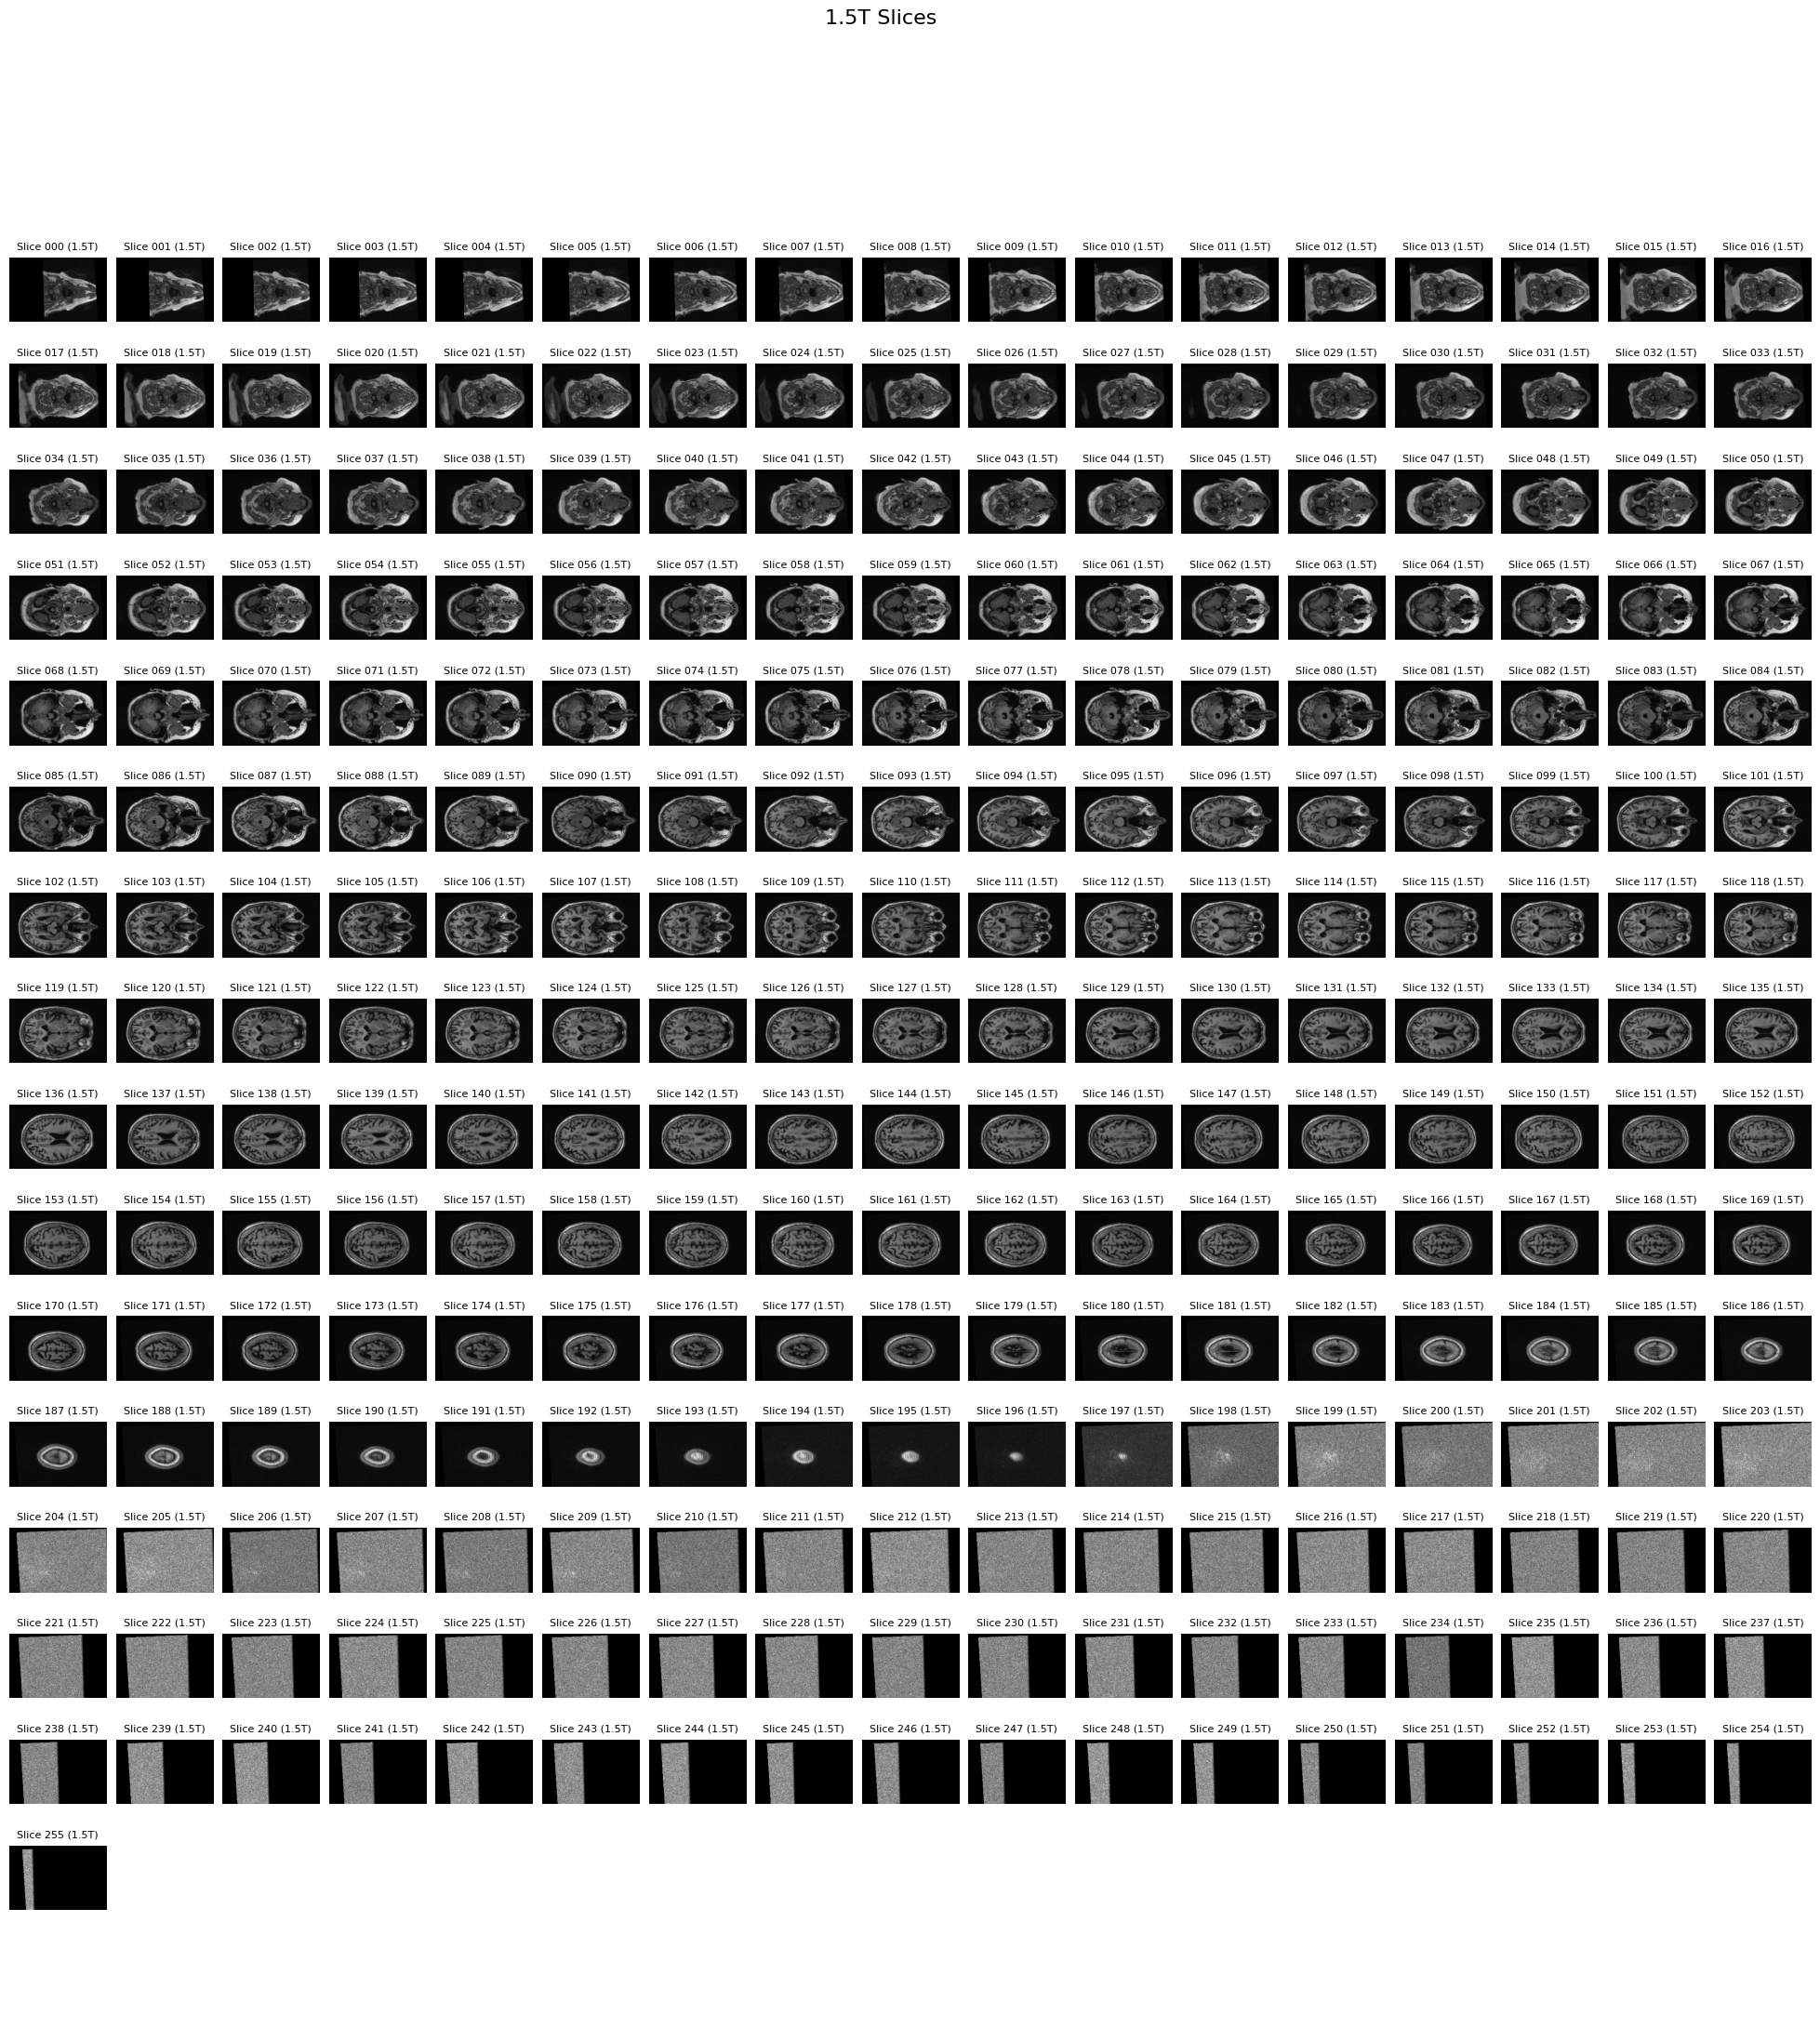

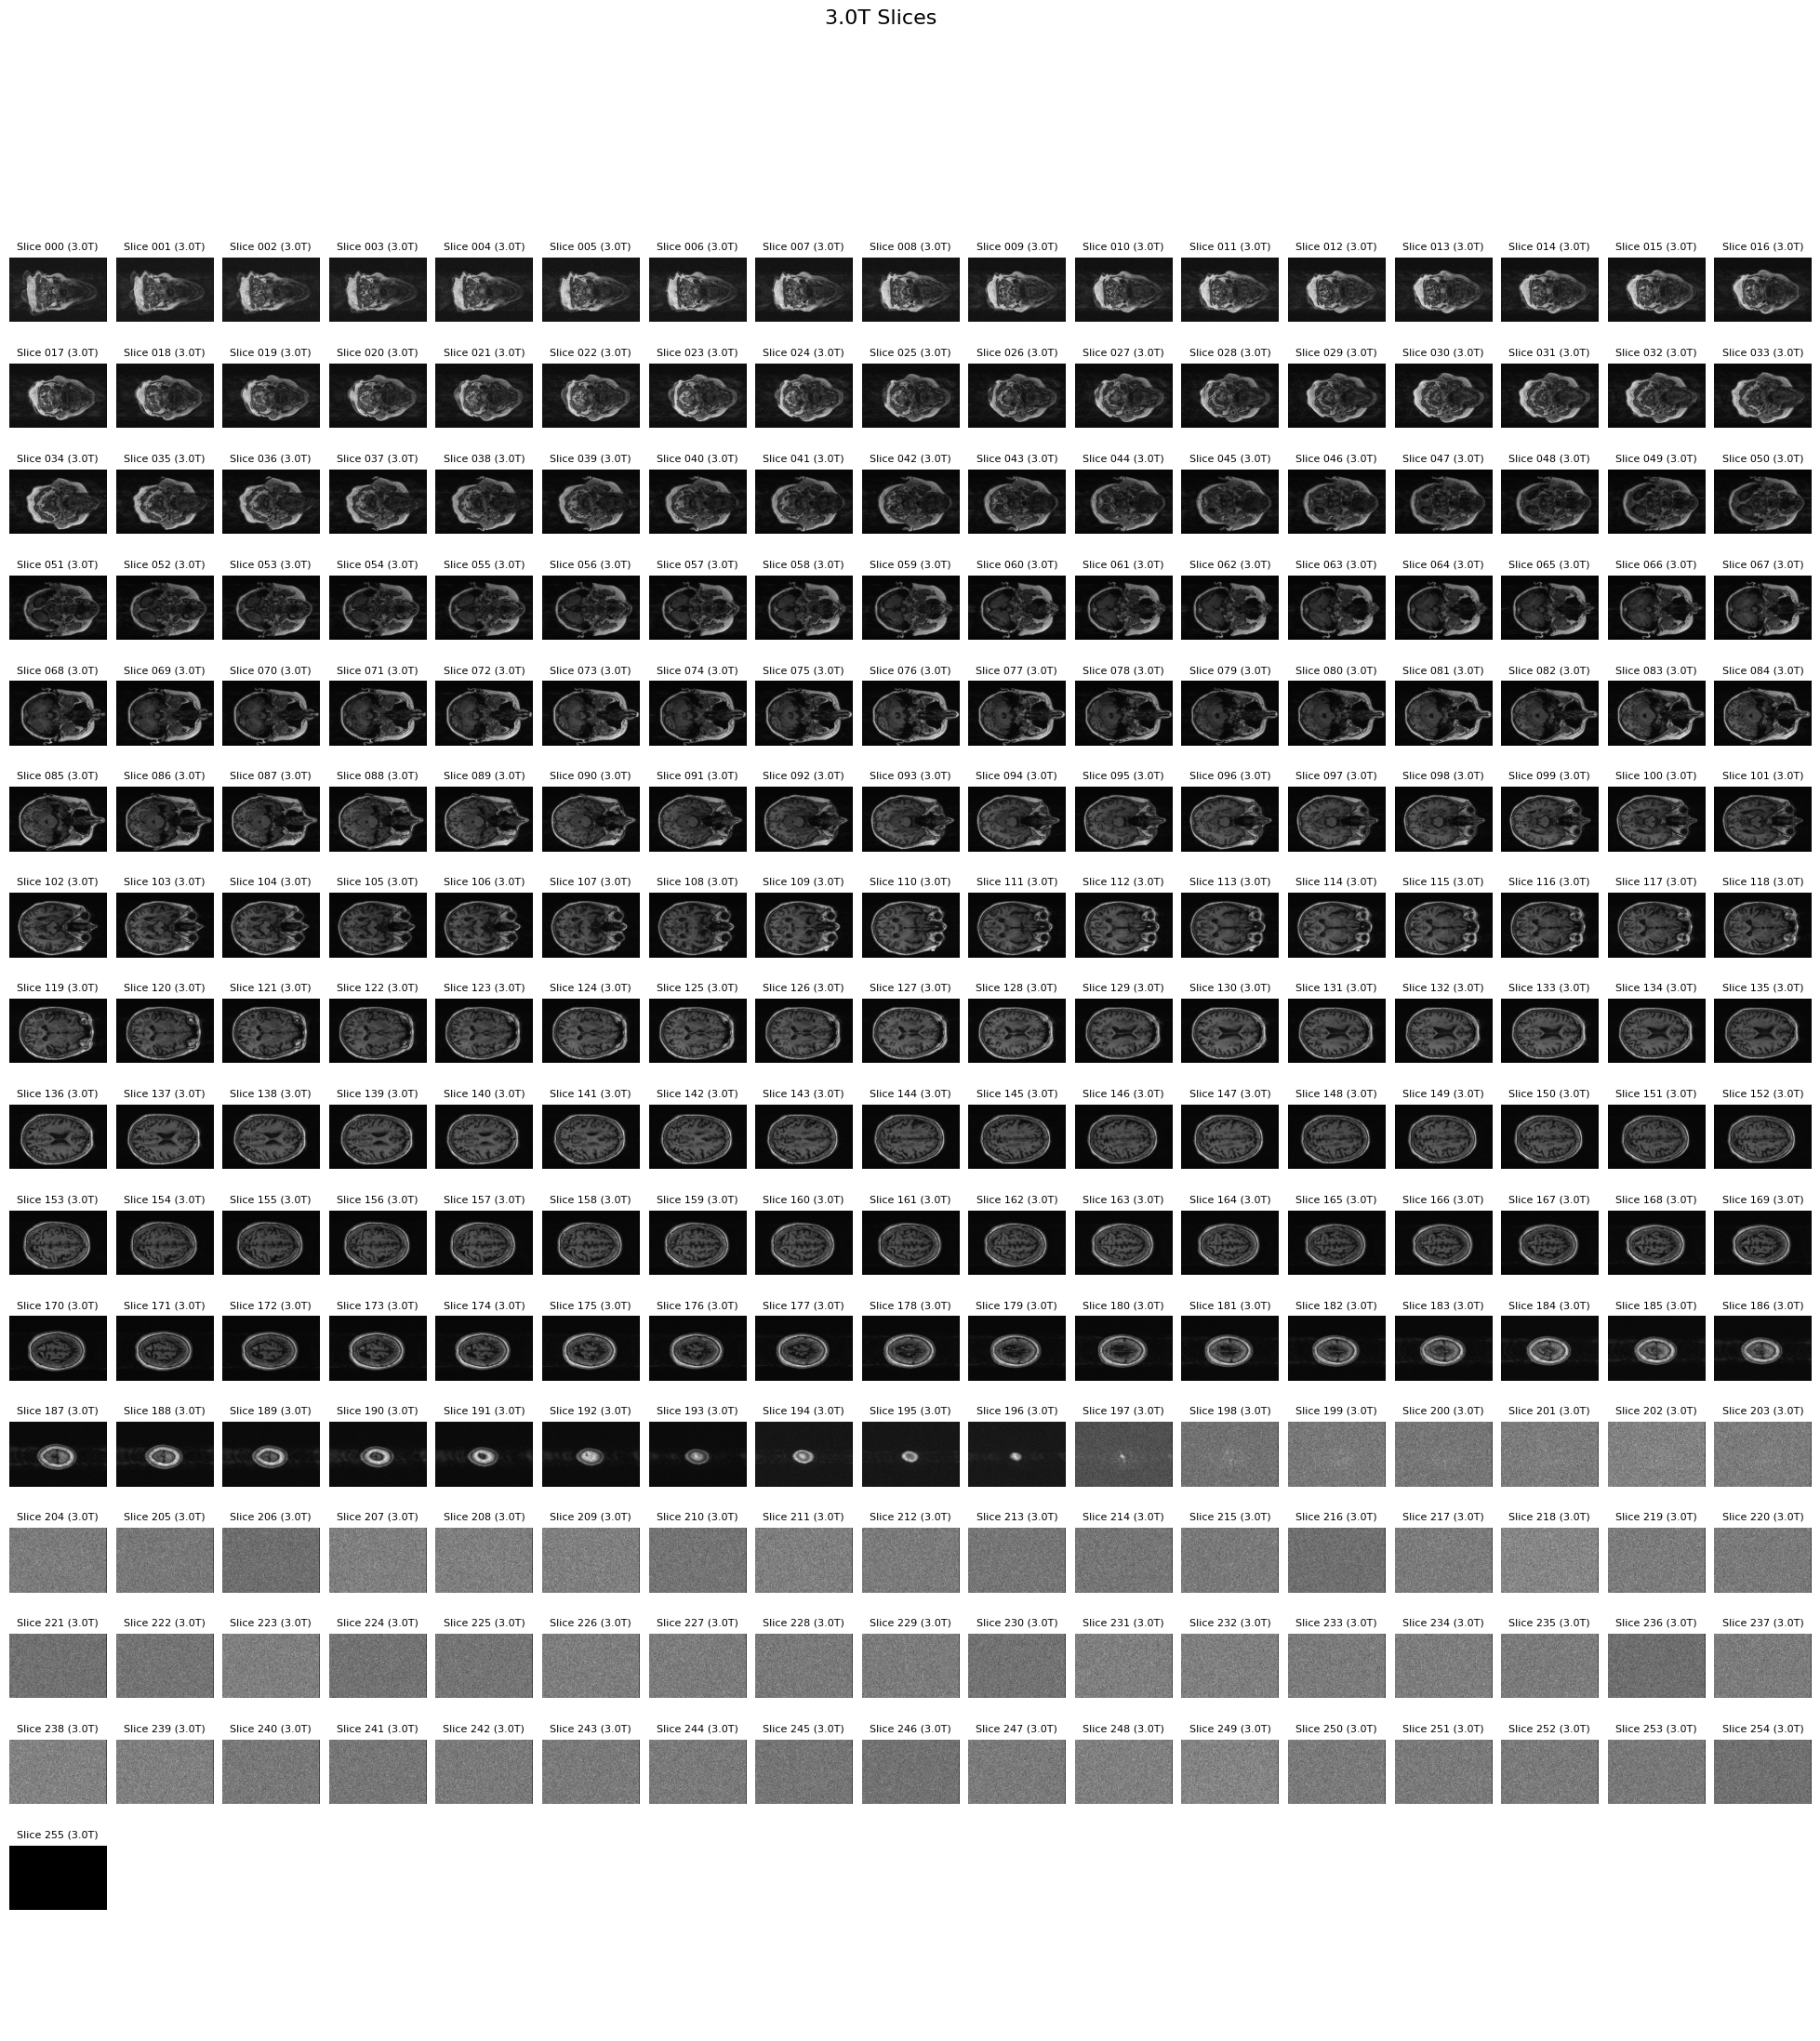

In [6]:
patient_id_to_visualize = '0031'  
visualize_slices(patient_id_to_visualize)


In [1]:
import os

dataset_dir = "/scratch/Costanza/ADNI_DDPM_S_R_PNG"

patient_ids = sorted([patient_id for patient_id in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, patient_id))])

for patient_id in patient_ids:
    print(patient_id)


0021
0023
0031
0056
0058
0059
0061
0089
0156
0173
0257
0260
0311
0359
0369
0405
0416
0479
0553
0555
0602
0605
0622
0677
0767
0926
0963
1023
1035
1123
1169
1190
1194
1195
1202
1203
1206
1241
1250
1251
1256
1267
1276
1288
